# working file : it.1

In [1]:
# coding: utf-8
from lxml import etree
from matplotlib import pyplot as plt
import numpy as np
import time
import csv
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math
from numpy import log as ln
from sklearn.metrics import r2_score

# Travel time and distance

In [3]:
# parse and read plans.xml file
it_id = '1'
fname = '/Users/xinyun/Documents/Stage4A/MATSim_output_MFD/it.'+it_id+'/'+it_id+'.plans.xml'
tree = etree.parse(fname)

In [4]:
i = 0
i_car = 0
tt_car, dist_car, dep_t_car = ([] for i in range(3))
for user in tree.xpath('/population/person'):
    plans = user.xpath('plan')
    for plan in plans:
        i+=1
        car = False
        if plan.get('selected') == 'yes':
            legs = plan.xpath('leg')
            for leg in legs:
                mode = leg.get('mode')
                if (mode == 'car'):
                    car = True
               # get travel time, departure time and travel distance for only car uers
                if car: 
                    tt_car.append(leg.get('trav_time'))
                    dep_t_car.append(leg.get('dep_time'))
                    dist_car.append(leg.xpath('route')[0].get('distance'))
    if car:
        i_car+=1
# print the number of trips realized by users and the number of car used by users.
print(i, i_car)                

160206 54414


In [5]:
print(tt_car[0], dist_car[0], dep_t_car[0])
print(len(tt_car))

00:14:50 5768.524388870968 09:05:53
217144


In [6]:
print(len(tt_car), len(dist_car), len(dep_t_car))

217144 217144 217144


In [7]:
# turn all time values to second
tt_car2 = np.asarray([float(t[:2])*3600 + float(t[3:5])*60 + float(t[6:8]) for t in tt_car])
dep_t_car2 = np.asarray([float(t[:2])*3600 + float(t[3:5])*60 + float(t[6:8]) for t in dep_t_car])
dist_car2 = np.asarray([np.floor(float(d)) for d in dist_car])

In [8]:
# fill nan in dist_car2
dist_car2 = np.nan_to_num(dist_car2, nan=np.nanmean(dist_car2))
np.isnan(dist_car2).any()

False

### Plot travel time and distance

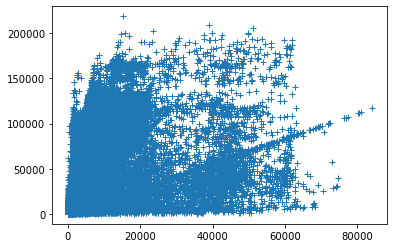

In [9]:
plt.figure()
plt.plot(tt_car2,dist_car2,'+')

/var/folders/rn/l0_f8pz15050p66fqtz1164h0000gp/T/ipykernel_6994/2382424051.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dep_t_car2/3600,dist_car2/tt_car2,'+')
/var/folders/rn/l0_f8pz15050p66fqtz1164h0000gp/T/ipykernel_6994/2382424051.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(dep_t_car2/3600,dist_car2/tt_car2,'+')


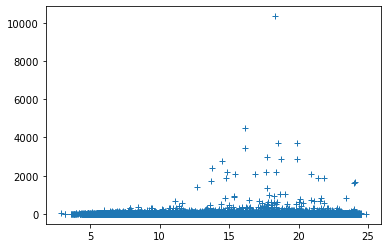

In [10]:
plt.figure()
plt.plot(dep_t_car2/3600,dist_car2/tt_car2,'+') 

# Car accumulation

In [11]:
# parse and read events.xml file
fname2 = '/Users/xinyun/Documents/Stage4A/MATSim_output_MFD/it.'+it_id+'/'+it_id+'.events.xml'
tree2 = etree.parse(fname2)

In [13]:
# calculate car accumulation
time_acc_car = []
acc_car = []
acc = 0
i_car_in = 0
i_car_out = 0
for event in tree2.xpath("/events/event"):
    car = False
    if event.get('networkMode') == "car":
        car = True
        if event.get('type') == "vehicle enters traffic":
            acc+=1
            i_car_in+=1
        if event.get('type') == "vehicle leaves traffic":
            acc-=1
            i_car_out+=1
    if car:
        acc_car.append(acc)
        time_acc_car.append(event.get('time'))
print('car in :', i_car_in, 'car out :', i_car_out)

car in : 59526 car out : 50242


In [14]:
time_acc_car2 = np.asarray([float(t) for t in time_acc_car])
acc_car2 = np.asarray([a for a in acc_car])

### Plot car accumlation

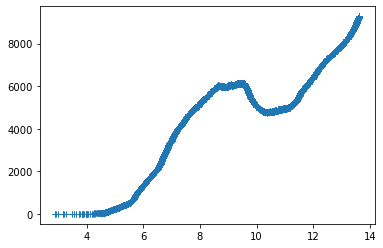

In [15]:
plt.figure()
plt.plot(time_acc_car2/3600, acc_car2, '+')

# MFD

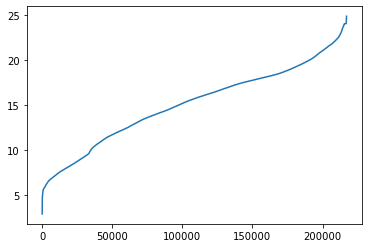

In [19]:
delta_t = 60 # time interval for speed computation  1mn
id_dept = np.argsort(dep_t_car2)   # index of sorted values
plt.figure()
plt.plot(dep_t_car2[id_dept]/3600)

In [64]:
# get var accumulation and car speed for each time interval (1mn)
nb_per = 24*3600//delta_t
mfd_acc = np.zeros(nb_per)
mfd_speed = np.zeros(nb_per)
mfd_weights = np.zeros(nb_per)
i_tt=0
i_event=0
for i_per in range(nb_per):
    i_tt_old=i_tt
    i_event_old=i_event
    t_temp = i_per*delta_t
    # get departure times in ascending order
    while dep_t_car2[id_dept[i_tt]] < t_temp and i_tt < len(dep_t_car2)-1:
        i_tt += 1
    # get the number of events in each time interval (1mn)
    while time_acc_car2[i_event] < t_temp and i_event < len(time_acc_car2)-1:
        i_event += 1
    # If any event occurs within this time interval
    if i_tt_old != i_tt and i_event_old != i_event and sum(tt_car2[id_dept[i_tt_old:i_tt]])>0:
        # Use the average speed of the car in this time interval as the mfd speed in this time interval
        mfd_speed[i_per] = sum(dist_car2[id_dept[i_tt_old:i_tt]])/sum(tt_car2[id_dept[i_tt_old:i_tt]])
        # print(i_per, mfd_speed[i_per])
        mfd_acc[i_per] = np.mean(acc_car2[i_event_old:i_event])
        mfd_weights[i_per] = 1

### Plot car accumulation and speed

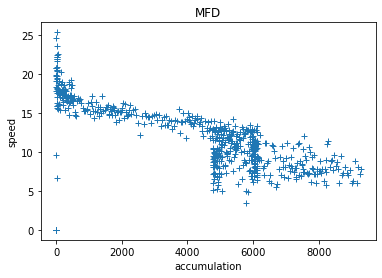

In [62]:
df2 = pd.DataFrame({'x':mfd_acc, 'y':mfd_speed})
plt.figure()
plt.xlabel('accumulation')
plt.ylabel('speed')
plt.title('MFD')
plt.plot(mfd_acc, mfd_speed, '+')

# Clean data before regression

### Remove zero velocity from mfd list

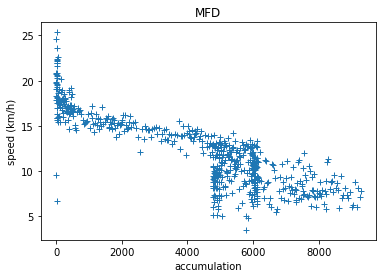

In [83]:
# y_ = log(y)
l1 = [i for i in mfd_speed if i != 0]
l2 = [i for i in mfd_acc if i != 0]
mfd_speed3 = np.asarray(l1)
mfd_acc3 = np.asanyarray(l2)
plt.figure()
plt.xlabel('accumulation')
plt.ylabel('speed (km/h)')
plt.title('MFD')
plt.plot(mfd_acc3, mfd_speed3, '+')
plt.savefig('cleaned_mfd.pdf')
plt.show()

# Regression
## In this part I used the MFD given in the article "Empirical MFDs using Google Traffic Data" : $V = V_0 \cdot \frac{-N}{e^{2 \cdot N_{crit}}}$,  where $V$ represent speed and $N$ represent accumulation, $V_0$ and $N_{crit}$ are variables that I gonna find.


## 1st method (Linear Regression by doing log transforamtion) - which I used

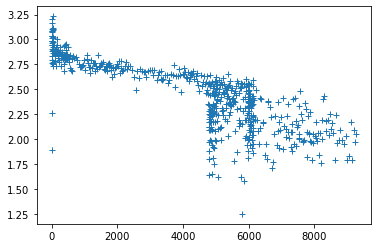

In [90]:
# y_ = ln(y)
y_ = ln(mfd_speed3)
x_ = mfd_acc3
df3 = pd.DataFrame({'x':x_, 'y':y_})
plt.figure()
plt.plot(x_, y_, '+')

### Check relationship between x and y

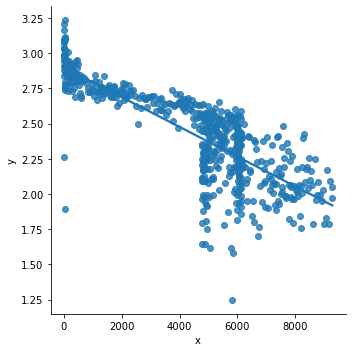

In [25]:
sns.lmplot(x ="x", y ="y", data = df3, order = 1, ci = None)

### Linear Regression of log transformation of the speed

Estimated coefficients:
a = 2.8981940480441857            
b = -0.00010553060526140915


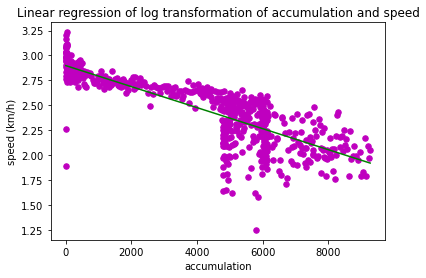

In [112]:
coef_ = estimate_coef(x_, y_)
a = coef_[0]
b = coef_[1]
plt.xlabel('accumulation')
plt.ylabel('ln(speed) (km/h)')
plt.title('Linear regression of log transformation of accumulation and speed')
print("Estimated coefficients:\na = {}  \
          \nb = {}".format(coef_[0], coef_[1])) 
# plotting regression line
plot_regression_line(x_, y_, coef_)

In [104]:
print("R2-score: %.2f" % r2_score(a + b*x_, y_))

R2-score: 0.49


### Exponential transformation : $V = e^{a - b \cdot N}$

In [116]:
def func(N, a, b):
    return np.exp(a + N*b)

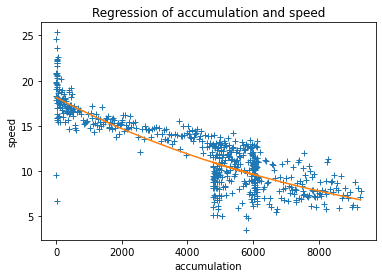

In [123]:
plt.figure()
plt.xlabel('accumulation')
plt.ylabel('speed')
plt.title('Regression of accumulation and speed')
N = mfd_acc3
plt.plot(mfd_acc3, mfd_speed3, '+', N, func(N, a, b) , '-')
plt.savefig('exp_transform.pdf')

In [124]:
print("R2-score: %.2f" % r2_score(func(mfd_acc3, a, b) , mfd_speed3))

R2-score: 0.65


# 2nd methode (Linear Regression by calculating coefficient $a$ and $b$)

In [35]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
  
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
  
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
  
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)

In [86]:
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
               marker = "o", s = 30)
  
    # predicted response vector
    y_pred = b[0] + b[1]*x
  
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
  
    # putting labels
    plt.xlabel('accumulation')
    plt.ylabel('speed (km/h)')
  
    # function to show plot
    plt.savefig('linearreg_only.pdf')
    plt.show()

Estimated coefficients:
b_0 = 2.8981940480441857            
b_1 = -0.00010553060526140915


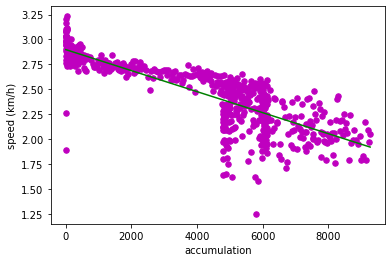

In [87]:
coef = estimate_coef(mfd_acc3, ln(mfd_speed3))
b_0 = coef[0]
b_1 = coef[1]
print("Estimated coefficients:\nb_0 = {}  \
          \nb_1 = {}".format(coef[0], coef[1])) 
# plotting regression line
plot_regression_line(mfd_acc3, ln(mfd_speed3), coef)

In [38]:
print("R2-score: %.2f" % r2_score(b_0 + b_1*mfd_acc3 , ln(mfd_speed3)))

R2-score: 0.49


### Exponential transformation

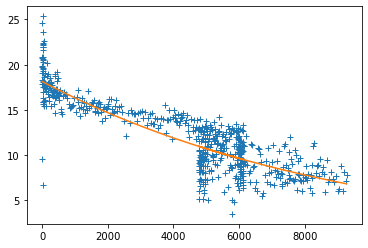

In [39]:
plt.figure()
plt.plot(mfd_acc3, mfd_speed3, '+', t, func(t, b_0, b_1) , '-')

In [40]:
print("R2-score: %.2f" % r2_score(func(mfd_acc3, b_0, b_1) , mfd_speed3))

R2-score: 0.65


# 3rd method

In [125]:
def func_exp(N, a, b):
    return a*np.exp(-N/(2*b))

In [126]:
def plot_regression(x, y):
    popt, pcov = curve_fit(lambda N,a,b: func_exp(N, a, b), x, y)
    a_ = popt[0]
    b_ = popt[1]
    N = x
    plt.plot(x, y, '+', N, func_exp(N, a_, b_) , '-')

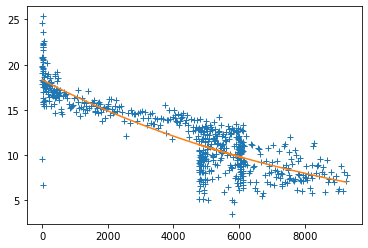

In [127]:
plot_regression(mfd_acc3, mfd_speed3)

In [128]:
popt, pcov = curve_fit(lambda t,a,b: func_exp(t, a, b), mfd_acc3, mfd_speed3)
a_ = popt[0]
b_ = popt[1]
print(a_, b_)

18.323199544221808 4813.38024078608


In [129]:
print("R2-score: %.2f" % r2_score( func_exp(t, a_, b_) , mfd_speed3))

R2-score: 0.66


# 4th method (Linear Regression) $V = b_0 + b_1 \cdot N$

Estimated coefficients:
b_0 = 17.766724007367525            
b_1 = -0.0013037359466655776


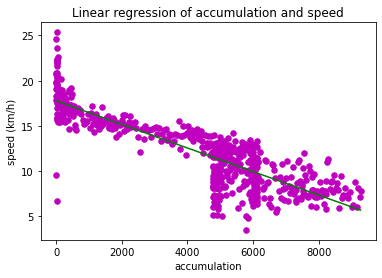

<Figure size 432x288 with 0 Axes>

In [88]:
coef_ = estimate_coef(mfd_acc3, mfd_speed3)
b_0 = coef_[0]
b_1 = coef_[1]
plt.xlabel('accumulation')
plt.ylabel('speed (km/h)')
plt.title('Linear regression of accumulation and speed')
print("Estimated coefficients:\nb_0 = {}  \
          \nb_1 = {}".format(coef_[0], coef_[1])) 
# plotting regression line
plot_regression_line(mfd_acc3, mfd_speed3, coef_)
plt.savefig('linear_only.pdf')

In [47]:
print("R2-score: %.2f" % r2_score(b_0 + b_1*mfd_acc3, mfd_speed3))

R2-score: 0.64


# Accuracy test for all methods

## 1st

In [48]:
x = mfd_acc3 
y = mfd_speed3
df_ = pd.DataFrame({'x': x, 'y': y}) # build dataframe
msk = np.random.rand(len(df_)) < 0.8
train_x = x[msk]
test_x = x[~msk]
train_y = y[msk]
test_y = y[~msk]
# build the model using train set
y_hat = func(test_x, a, b)
#y_hat = a*np.exp(-test_x/(2*b))
# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y))

Mean absolute error: 1.37
Residual sum of squares (MSE): 3.01
R2-score: 0.72


## 2nd

In [49]:
x = mfd_acc3
y = mfd_speed3
df_ = pd.DataFrame({'x': x, 'y': y}) # build dataframe
msk = np.random.rand(len(df_)) < 0.8
train_x = x[msk]
test_x = x[~msk]
train_y = y[msk]
test_y = y[~msk]
coef = estimate_coef(train_x, ln(train_y))
b_0 = coef[0]
b_1 = coef[1]
# build the model using train set
y_hat = func(test_x, b_0, b_1)
# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y))

Mean absolute error: 1.41
Residual sum of squares (MSE): 3.13
R2-score: 0.71


## 3rd

In [50]:
x = mfd_acc3 
y = mfd_speed3
df_ = pd.DataFrame({'x': x, 'y': y}) # build dataframe
msk = np.random.rand(len(df_)) < 0.8
train_x = x[msk]
test_x = x[~msk]
train_y = y[msk]
test_y = y[~msk]

popt, pcov = curve_fit(lambda t,a,b: func_exp(t, a, b), train_x, train_y)
a_ = popt[0]
b_ = popt[1]
# build the model using train set
y_hat = func_exp(test_x, a_, b_)
# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y))

Mean absolute error: 1.53
Residual sum of squares (MSE): 3.57
R2-score: 0.69


# 4th

In [51]:
x = mfd_acc3
y = mfd_speed3
df_ = pd.DataFrame({'x': x, 'y': y}) # build dataframe
msk = np.random.rand(len(df_)) < 0.8
train_x = x[msk]
test_x = x[~msk]
train_y = y[msk]
test_y = y[~msk]
coef_ = estimate_coef(train_x, train_y)
b_0 = coef_[0]
b_1 = coef_[1]
# build the model using train set
y_hat = b_0 + b_1*test_x
# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y))

Mean absolute error: 1.69
Residual sum of squares (MSE): 4.66
R2-score: 0.63
